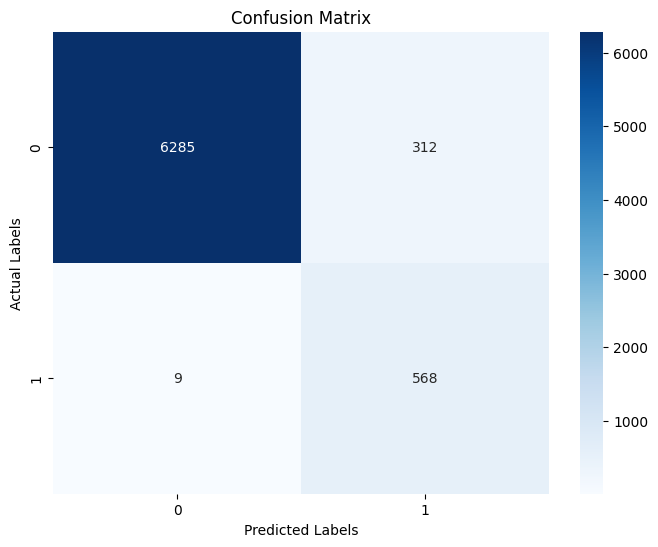

              precision    recall  f1-score   support

         1.0       1.00      0.95      0.98      6597
         2.0       0.65      0.98      0.78       577

    accuracy                           0.96      7174
   macro avg       0.82      0.97      0.88      7174
weighted avg       0.97      0.96      0.96      7174



In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



################################################################################
'''Esta parte se trata de manejar la data, aca la limpio de NaNs, luego quito filas
donde la altura es igual a 0, tambien vuelvo la multiclase binaria al convertir los 3 en 2
luego hago "feature engineering" creando nuevas columnas a partir de los datos existentes,
a lo ultimo hago uso de un scaler para normalizar valores para que el modelo lea los valores
numericos de manera mejor. Se usa mas que todo para valores numericos continuos.'''


# Load your dataset
df = pd.read_csv("df.CSV")

#clean df
df = df.dropna()

# Drop columns where "height" is equal to zero
df = df[df['height'] != 0]
df = df[df['weight'] != 0]
df.loc[df['cancer_p_status'] == 3, 'cancer_p_status'] = 2

# Reset the index
df.reset_index(drop=True, inplace=True)

# Calculate BMI
df['bmi'] = (df['weight'] / (df['height'] ** 2)).round(2)

# Create the product of age and cancer age
df['age_times_cancer_age'] = (df['age'] * df['cancer_age']).round(2)

# Change the data type of a column from float to int
df['age_times_cancer_age'] = df['age_times_cancer_age'].astype(int)

# Create Cancer Age Category feature
def categorize_cancer_age(age):
    if age < 40:
        return 'Early Age'
    elif age < 60:
        return 'Middle Age'
    else:
        return 'Late Age'

df['cancer_age_category'] = df['age'].apply(categorize_cancer_age)

# Convert categorical column to numerical using LabelEncoder
label_encoder = LabelEncoder()
df['cancer_age_category'] = label_encoder.fit_transform(df['cancer_age_category'])

# Create Number of Health Conditions feature
health_conditions = ['health', 'heart_atk', 'heart_dis', 'stroke', 'asma']  # Add other health conditions if needed
df['num_health_conditions'] = df[health_conditions].sum(axis=1)
df.fillna(0, inplace=True)

# Initialize scalers
rob_scaler = RobustScaler()

# Select columns to scale
columns_to_scale = ['age', 'height', 'drik_month', 'age_times_cancer_age', 'sleep_hr', 'cancer_age', 'cancer_type']

# Apply scaling using RobustScaler
for column in columns_to_scale:
    df[f'scaled_{column}'] = rob_scaler.fit_transform(df[column].values.reshape(-1, 1))

# Drop the original unscaled columns
df.drop(columns=columns_to_scale, axis=1, inplace=True)

#########################################################################################################################
'''Aca dejamos la data y nos concentramos en el modelo. Use randomforest por mejor facilidad y usando valores por defecto;
los modelos boosting tambien dan buenos valores aunque tuve preferencia por RF. Combine esto junto con cross-validation ya que
me permitia aplicar de forma correcta el SMOTE. La forma incorrecta de usar el SMOTE seria haciendolo antes del cross-validation
y/o antes de entrenar el modelo; pues existe la posibilidad de que los valores creados por el SMOTE se usaran para la validacion,
y por eso decidi aplicar el SMOTE dentro del proceso de validacion que seria la forma correcta de hacerlo.'''

# Split data into features (X) and target (y)
X = df.drop(columns=['cancer_p_status'])
y = df['cancer_p_status']

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier (RandomForest in this example)
rf_model = RandomForestClassifier(random_state=42)

# Initialize variables to track the best model
best_model = None
best_f1_score = 0.0


for train_idx, val_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Apply SMOTE-ENN resampling on the training data
    resampling_technique = SMOTEENN(sampling_strategy='all')
    X_train_resampled, y_train_resampled = resampling_technique.fit_resample(X_train, y_train)

    # Train the model on the resampled training data
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the validation data
    y_pred = rf_model.predict(X_val)

    # Evaluate the model using F1 score
    f1 = f1_score(y_val, y_pred, average='macro')

    # Check if this model has the best F1 score so far
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = rf_model

# Use the best model to make predictions on the entire dataset
y_pred = best_model.predict(X_val)

#best_model is best model if needed to save


# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_val, y_pred)
print(report)

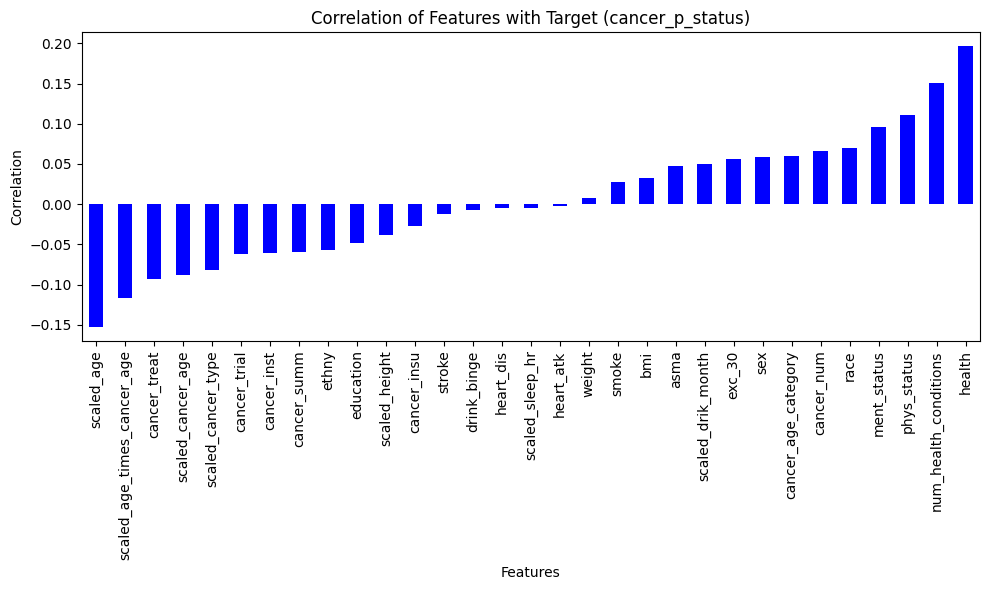

In [ ]:
#Esto es solo para poder observar la correlacion de los features con respecto a la clase

# Calculate the correlation between each feature and the target variable
correlation_with_target = df.corr()["cancer_p_status"]

# Exclude the target variable itself from the correlation calculation
correlation_with_target = correlation_with_target.drop("cancer_p_status")

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a bar plot for the correlations with the target
correlation_with_target.sort_values().plot(kind="bar", color="blue")

# Set title and labels
plt.title("Correlation of Features with Target (cancer_p_status)")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()
plt.show()

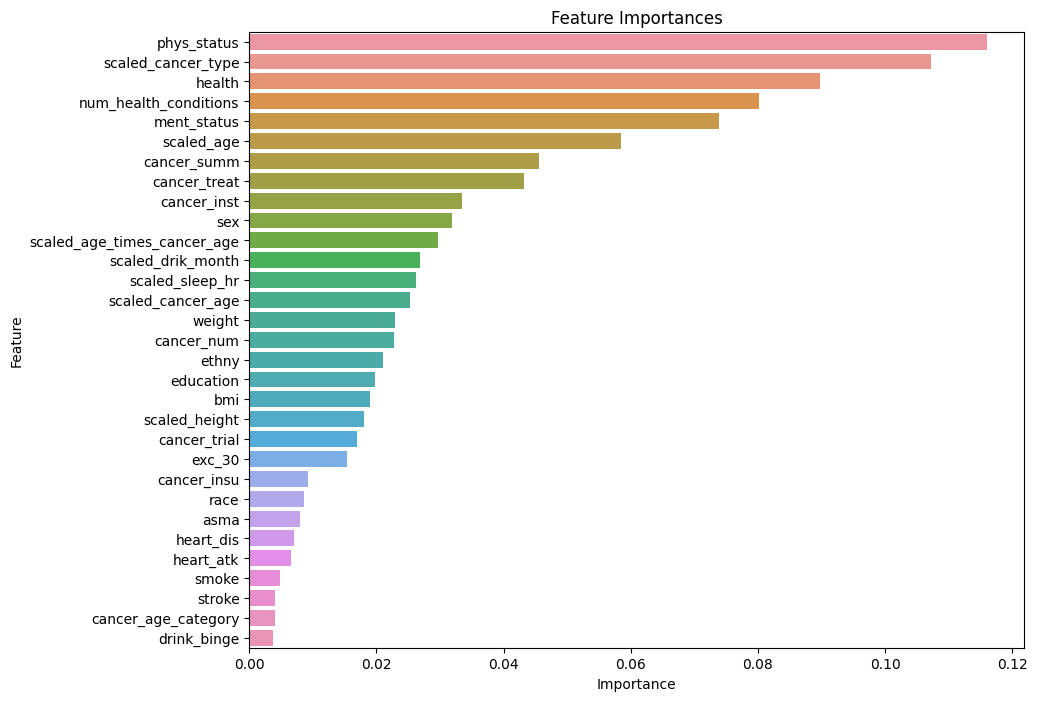

In [ ]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()